Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0171 - val_loss: 1.6686e-04
Epoch 2/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0015 - val_loss: 1.1214e-04
Epoch 3/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0012 - val_loss: 1.0633e-04
Epoch 4/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0010 - val_loss: 9.7560e-05
Epoch 5/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 9.0852e-04 - val_loss: 9.6537e-05
Epoch 6/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7.3453e-04 - val_loss: 1.0578e-04
Epoch 7/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.7709e-04 - val_loss: 1.3558e-04
Epoch 8/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4.6231e-04 - val_loss: 9.0109e-05
Epoch 9/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.7877e-04 - val_loss: 1.1437e-04
Epoch 10/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.1445e-04 - val_loss: 7.7050e-05
Epoch 11/40
447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.3464e-04 - val_loss: 9.

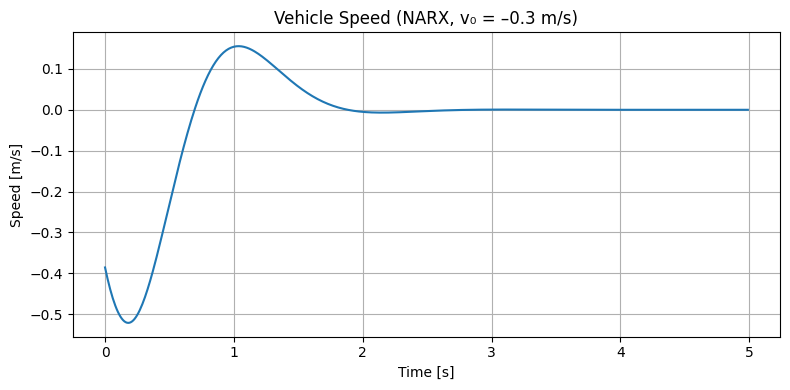

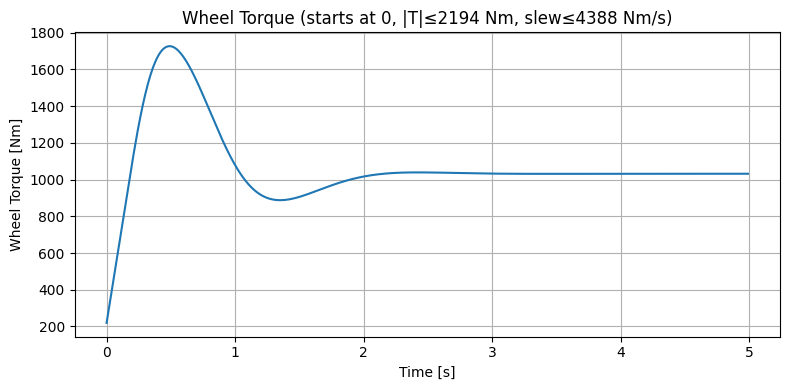

In [4]:
# hill_assist_narx_slew_teacher.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ───────────────────────── 0) SABİTLER ─────────────────────────
np.random.seed(42); tf.random.set_seed(42)

m, r_tire, g = 1500.0, 0.35, 9.81
theta = np.deg2rad(11.5)
F_dist = m*g*np.sin(theta) + 14.0

gear_ratio, eff = 12.5, 0.90
T_MAX  = 150 * gear_ratio * eff * 1.30     # ≈ 2 194 Nm
T_SLEW = 2 * T_MAX                         # ≈ 4 388 Nm s⁻¹

Kp, Ki, Kd = 4_000.0, 8_000.0, 80.0        # öğretmen PID
dt, t_end = 0.01, 5.0
N  = int(t_end/dt)
time = np.arange(N)*dt

# yardımcı: slew-rate filtresi
def slew_filter(T_cmd, T_act):
    dT_allowed = T_SLEW * dt
    return T_act + np.clip(T_cmd - T_act, -dT_allowed, dT_allowed)

# ─────────── 1) PID öğretmeni (T_act 0’dan başlar) ───────────
def pid_episode(v0):
    v, int_e, prev_e, T_act = v0, 0.0, 0.0, 0.0
    rows = []
    for _ in range(N):
        e   = -v
        int_e += e*dt
        de  = (e - prev_e)/dt
        prev_e = e

        T_cmd = np.clip(Kp*e + Ki*int_e + Kd*de, -T_MAX, T_MAX)
        T_act = slew_filter(T_cmd, T_act)

        v += ((T_act/r_tire) - F_dist) / m * dt
        rows.append([v, e, int_e, de, T_act])
    return np.array(rows)                           # (N,5)

# ─────────── 2) Veri seti: 6 hız × 12 varyasyon ───────────
init_speeds = [0.0, -0.1, -0.2, -0.4, -0.6, -0.8]
episodes = [pid_episode(v0+np.random.normal(0,0.02))
            for v0 in init_speeds for _ in range(12)]

# NARX pencere boyu
k_lag = 4
X_seq, y_seq = [], []
for ep in episodes:
    for t in range(k_lag, N):
        X_seq.append(ep[t-k_lag:t, :])      # (k,5)  -> [v,e,∫e,de,T_prev]
        y_seq.append(ep[t, 4])              # hedef  -> T_act(t)

X_seq = np.array(X_seq)                     # (samples, k, 5)
y_seq = np.array(y_seq).reshape(-1,1)       # (samples, 1)

# ölçekleme
x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X_seq.reshape(-1,5)).reshape(X_seq.shape)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_seq)

X_tr,X_te,y_tr,y_te = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=True, random_state=42)

# ─────────── 3) NARX-LSTM modeli ───────────
model = Sequential([
    LSTM(64, input_shape=(k_lag,5)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_tr, y_tr, epochs=40, batch_size=64,
          validation_data=(X_te, y_te), verbose=1)

# ─────────── 4) NARX ile simülasyon (v₀ = –0.3 m/s) ───────────
def simulate_narx(v0):
    # ilk k_lag adımı PID ile “ısınma” (T_act rampalı)
    warm = pid_episode(v0)[:k_lag]
    window = warm.copy()                    # (k,5)

    v, int_e, prev_e, T_act = warm[-1,0], warm[-1,2], -warm[-1,0], warm[-1,4]
    v_log, T_log = [], []

    for _ in range(N):
        # ağ tahmini
        x_in = x_scaler.transform(window).reshape(1,k_lag,5)
        T_cmd = y_scaler.inverse_transform(model.predict(x_in, verbose=0))[0,0]
        T_cmd = np.clip(T_cmd, -T_MAX, T_MAX)
        T_act = slew_filter(T_cmd, T_act)

        # araç dinamiği
        e   = -v
        int_e += e*dt
        de  = (e - prev_e)/dt
        prev_e = e
        v += ((T_act/r_tire) - F_dist) / m * dt

        # pencereyi güncelle
        new_row = np.array([v, e, int_e, de, T_act])
        window = np.vstack([window[1:], new_row])

        v_log.append(v); T_log.append(T_act)

    return np.array(v_log), np.array(T_log)

v_narx, T_narx = simulate_narx(-0.3)

# ─────────── 5) Grafikler ───────────
plt.figure(figsize=(8,4))
plt.plot(time, v_narx)
plt.xlabel('Time [s]'); plt.ylabel('Speed [m/s]')
plt.title('Vehicle Speed (NARX, v₀ = –0.3 m/s)')
plt.grid(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(time, T_narx)
plt.xlabel('Time [s]'); plt.ylabel('Wheel Torque [Nm]')
plt.title(f'Wheel Torque (starts at 0, |T|≤{T_MAX:.0f} Nm, slew≤{T_SLEW:.0f} Nm/s)')
plt.grid(); plt.tight_layout(); plt.show()
